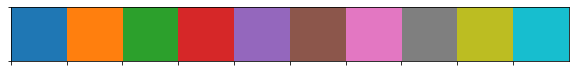

In [4]:
import numpy as np
import pandas as pd
import numba
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import sklearn.manifold as skman
import sklearn.decomposition as decomp
from sklearn import cluster
import umap
from sklearn import svm
import tslearn

def get_colorlist(labels, cmap=None):
    output = np.zeros((len(labels), 3))
    for i, l in enumerate(labels):
        if cmap is None:
            color = sns.color_palette()[int(l)]
        elif type(cmap) is str:
            color = sns.color_palette(cmap)[int(l)]
        else:
            raise TypeError('cmap must be a string')
        output[i, :] = color
    return output

sns.palplot(sns.color_palette())

In [19]:
def u_start(dt, x):
    dx1 = dt[0]
    dx2 = dt[0]+dt[1]
    c = 1/(dx2*(1-dx2/dx1))
    b = -c*dx2**2/dx1**2
    a = -b-c
    return a*x[0]+b*x[1]+c*x[2]

def u_end(dt, x):
    dx1 = dt[-1]
    dx2 = dt[-1]+dt[-2]
    c = -1/(dx2*(1-dx2/dx1))
    b = -c*dx2**2/dx1**2
    a = -b-c
    return a*x[-1]+b*x[-2]+c*x[-3]

def coeffs(dx1, dx2):
    c = -dx1/(dx2*(dx2+dx1))
    a = (1+c*dx2)/dx1
#     c = -1/(dx2*(1+dx2/dx1))
#     a = -c*dx2**2/dx1**2
    b = -a-c
    return a, b, c

def velocities(x, t):
    u = np.zeros(x.shape)
    dt = t[1:] - t[:-1]
    #edge cases
    u[0] = u_start(dt, x)
    u[-1] = u_end(dt, x)
    for i in range(1, len(x)-1):
        a, b, c = coeffs(dt[i-1], dt[i])
        u[i] = a*x[i-1]+b*x[i]+c*x[i+1]
    return u

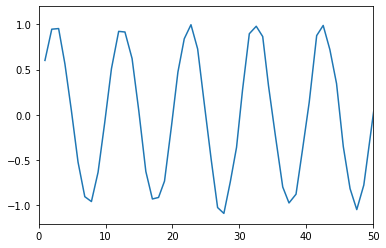

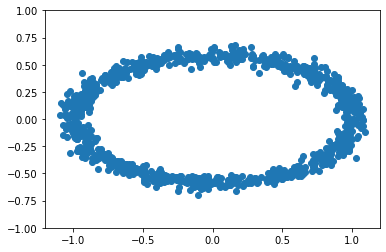

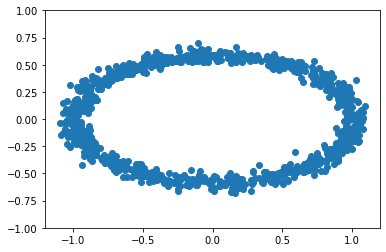

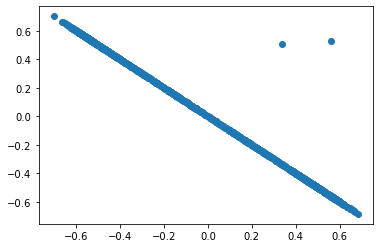

In [22]:
test = np.random.randn(1000)
t_samp = np.cumsum(np.abs(np.random.randn(1000)/20+1))
x = np.sin(2*np.pi*t_samp/10)+test/20
plt.plot(t_samp, x)
plt.xlim([0, 50])
plt.figure()
plt.scatter(x, np.gradient(x, t_samp))
plt.ylim([-1, 1])
plt.figure()
plt.scatter(x, velocities(x, t_samp))
plt.ylim([-1, 1])
plt.figure()
plt.scatter(np.gradient(x, t_samp), velocities(x, t_samp))

## Generate some example datasets

In [148]:
x_ar = np.zeros((80, 1000))
t_ar = np.zeros((80, 1000))
v_ar = np.zeros((80, 1000))

for k in range(20):
    phase = np.random.uniform()*2*np.pi
    t = np.cumsum(np.abs(np.random.randn(1000)/4+1))
    x = np.sin(2*np.pi*t+phase)
    t_ar[k, :] = t
    x_ar[k, :] = x
for k in range(20, 40):
    phase = np.random.uniform()*2*np.pi
    t = np.cumsum(np.abs(np.random.randn(1000)/4+1))
    x = np.sin(np.pi*t+phase)
    t_ar[k, :] = t
    x_ar[k, :] = x
for k in range(40, 60):
    const = np.random.uniform(-1, 1)
    t = np.cumsum(np.abs(np.random.randn(1000)/4+1))
    x = np.ones((1000,))*const
    t_ar[k, :] = t
    x_ar[k, :] = x
for k in range(60, 70):
    slope = np.random.uniform(0, 1)
    x0 = np.random.uniform(-0.5, 0)
    t = np.cumsum(np.abs(np.random.randn(1000)/4+1))
    x = x0+slope*t
    t_ar[k, :] = t
    x_ar[k, :] = x
for k in range(70, 80):
    slope = np.random.uniform(-1, 0)
    x0 = np.random.uniform(0, 0.5)
    t = np.cumsum(np.abs(np.random.randn(1000)/4+1))
    x = x0+slope*t
    t_ar[k, :] = t
    x_ar[k, :] = x

for k, (t, x) in enumerate(zip(t_ar, v_ar)):
    v_ar[k, :] = np.gradient(x, t)

labels = np.hstack([np.zeros(20,), np.ones(20,), np.ones(20,)*2, np.ones(10,)*3, np.ones(10,)*4])
colors = get_colorlist(labels)

In [149]:
data_ar = np.hstack([x_ar, v_ar])
data_ar.shape

(80, 2000)

(-1.0, 1.0)

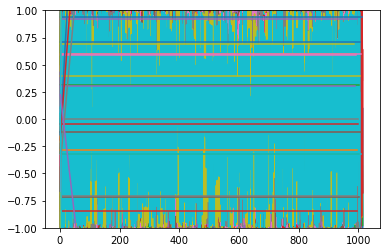

In [150]:
for k in range(80):
    plt.plot(t_ar[k, :], x_ar[k, :])
plt.gca().set_ylim([-1, 1])

array([[-4.11014434e-05, -9.88015225e-05, -1.56041876e-04, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.22275966e-02, -1.50832980e-02, -1.12829351e-02, ...,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
       [-4.70376474e-03, -1.48125166e-02, -8.03372483e-03, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 3.46551274e-03,  7.45181077e-02,  7.85524486e-03, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 5.94142041e-03, -1.34259330e-01,  1.94187038e-02, ...,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
       [ 2.28838661e-02,  1.08828624e-02,  3.64274074e-02, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

array([2.99526242e+07, 1.43376114e+02, 7.41038857e+01, 4.49131691e+01,
       2.80043728e+01, 1.25314452e+01, 1.05141372e+01, 1.04882738e+01,
       9.58708129e+00, 9.23558291e+00, 8.76319134e+00, 8.54598851e+00,
       8.01925601e+00, 7.97121813e+00, 7.91766821e+00, 7.62427184e+00,
       7.57082005e+00, 7.47030300e+00, 7.25533213e+00, 7.13830135e+00,
       6.99361223e+00, 6.94265146e+00, 6.67795633e+00, 6.61987238e+00,
       6.51211782e+00, 6.35306419e+00, 6.27796123e+00, 6.11566717e+00,
       6.06365356e+00, 5.96604916e+00, 5.73708250e+00, 5.67471965e+00,
       5.55685410e+00, 5.51257312e+00, 5.36122785e+00, 5.26290340e+00,
       5.22509179e+00, 5.16361753e+00, 5.07592334e+00, 4.99858253e+00,
       4.89530408e+00, 4.74400278e+00, 4.68238992e+00, 4.50958101e+00,
       4.25161701e+00, 4.22905930e+00, 4.14483762e+00, 3.84965941e+00,
       3.71100002e+00, 3.40612517e+00, 3.03987617e+00, 2.63314009e+00,
       2.18871255e+00, 1.49512483e+00, 1.33676483e+00, 7.72382733e-01,
      

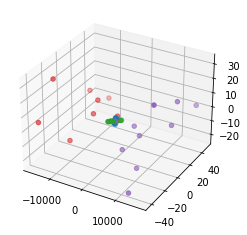

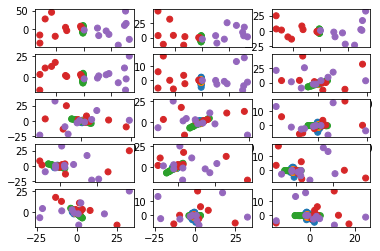

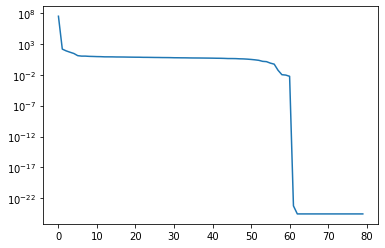

In [151]:
pca = decomp.PCA()
components = pca.fit_transform(data_ar)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(components[:, 0], components[:, 1], components[:, 3], c=colors)

fig, ax = plt.subplots(5, 3)
axi = ax.ravel()
axi[0].scatter(components[:, 0], components[:, 1], c=colors)
axi[1].scatter(components[:, 0], components[:, 2], c=colors)
axi[2].scatter(components[:, 0], components[:, 3], c=colors)
axi[3].scatter(components[:, 0], components[:, 4], c=colors)
axi[4].scatter(components[:, 0], components[:, 5], c=colors)
axi[5].scatter(components[:, 1], components[:, 2], c=colors)
axi[6].scatter(components[:, 1], components[:, 3], c=colors)
axi[7].scatter(components[:, 1], components[:, 4], c=colors)
axi[8].scatter(components[:, 1], components[:, 5], c=colors)
axi[9].scatter(components[:, 2], components[:, 3], c=colors)
axi[10].scatter(components[:, 2], components[:, 4], c=colors)
axi[11].scatter(components[:, 2], components[:, 5], c=colors)
axi[12].scatter(components[:, 3], components[:, 4], c=colors)
axi[13].scatter(components[:, 3], components[:, 5], c=colors)
axi[14].scatter(components[:, 4], components[:, 5], c=colors)
display(pca.components_)

plt.figure()
plt.semilogy(np.arange(len(pca.explained_variance_)), pca.explained_variance_)

display(pca.explained_variance_)

In [152]:
@numba.njit()
def xvcosine(x, y):
    length = x.shape[0]//2
    x1 = np.cumsum(x[:length])
    v1 = np.cumsum(x[length:2*length])
    x2 = np.cumsum(y[:length])
    v2 = np.cumsum(y[length:2*length])
    
    resx = np.dot(x1, x2)
    norm_x1 = np.dot(x1, x1)
    norm_x2 = np.dot(x2, x2)
    
    resv = np.dot(v1, v2)
    norm_v1 = np.dot(v1, v1)
    norm_v2 = np.dot(v2, v2)

    grad = np.zeros(x.shape)
    if norm_x1 == 0.0 and norm_x2 == 0.0 and norm_v1 == 0.0 and norm_v2 == 0.0:
        dist = 0.0
    elif norm_x1 == 0.0 or norm_x2 == 0.0 or norm_v1 == 0.0 or norm_v2 == 0.0:
        dist = 1.0
    else:
        dist = 1.0 - (resx/ np.sqrt(norm_x1 * norm_x2)) - (resv / np.sqrt(norm_v1 * norm_v2))
        grad[:length] = -(x1 * resx - x2 * norm_x1) / np.sqrt(norm_x1 ** 3 * norm_x2)
        grad[length:] = -(v1 * resv - v2 * norm_v1) / np.sqrt(norm_v1 ** 3 * norm_v2)
    return dist, grad


@numba.njit()
def correlation_grad(x, y):
    mu_x = 0.0
    mu_y = 0.0
    norm_x = 0.0
    norm_y = 0.0
    dot_product = 0.0

    for i in range(x.shape[0]):
        mu_x += x[i]
        mu_y += y[i]

    mu_x /= x.shape[0]
    mu_y /= x.shape[0]

    for i in range(x.shape[0]):
        shifted_x = x[i] - mu_x
        shifted_y = y[i] - mu_y
        norm_x += shifted_x ** 2
        norm_y += shifted_y ** 2
        dot_product += shifted_x * shifted_y

    if norm_x == 0.0 and norm_y == 0.0:
        dist = 0.0
        grad = np.zeros(x.shape)
    elif dot_product == 0.0:
        dist = 1.0
        grad = np.zeros(x.shape)
    else:
        dist = 1.0 - (dot_product / np.sqrt(norm_x * norm_y))
        grad = ((x - mu_x) / norm_x - (y - mu_y) / dot_product) * dist

    return dist, grad

@numba.njit()
def xvcorrelation(x, y):
    length = x.shape[0]//2
    x1 = np.cumsum(x[:length])
    v1 = np.cumsum(x[length:2*length])
    x2 = np.cumsum(y[:length])
    v2 = np.cumsum(y[length:2*length])
    distx, gradx = correlation_grad(x1, x2)
    distv, gradv = correlation_grad(v1, v2)
    grad = np.zeros(x.shape[0])
    grad[:length] = gradx
    grad[length:] = gradv
    dist = distx+distv
    return dist, grad

@numba.njit()
def xvtsmanhattan(xin, yin):
    """Manhattan, taxicab, or l1 distance with gradient.
    ..math::
        D(x, y) = \sum_i |x_i - y_i|
    """
    length = xin.shape[0]//2
    x = np.zeros(xin.shape[0])
    y = np.zeros(xin.shape[0])
    x[:length] = np.cumsum(xin[:length])
    x[length:] = np.cumsum(xin[length:])
    y[:length] = np.cumsum(yin[:length])
    y[length:] = np.cumsum(yin[length:])
    result = 0.0
    grad = np.zeros(x.shape)
    for i in range(x.shape[0]):
        result += (x[i] - y[i])**2
        grad[i] = np.sign(x[i] - y[i])
    grad = (x-y)/1e-6+result
    return result, grad


@numba.njit()
def crosscorr(x, y):
    x = x.astype(np.float64)
    y = y.astype(np.float64)
    cc = np.zeros(x.shape[0], dtype=np.float64)
    cc[0] = np.dot(x, y)
    for i in range(1, x.shape[0]//2):
        pad = np.zeros(i)
        cc[i] = np.dot(x[:i], pad)+np.dot(x[i:], y[i:])
    for i in range(1, x.shape[0]//2):
        pad = np.zeros(i)
        cc[-i] = np.dot(x[-i:], pad)+np.dot(x[:-i], y[i:])
    return np.max(np.sqrt(cc/np.sqrt(np.dot(x, x)*np.dot(y, y))))

/home/gknave/anaconda3/lib/python3.7/site-packages/umap/umap_.py:1496: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  "custom distance metric does not return gradient; inverse_transform will be unavailable. "
/home/gknave/anaconda3/lib/python3.7/site-packages/umap/umap_.py:1496: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  "custom distance metric does not return gradient; inverse_transform will be unavailable. "
/home/gknave/anaconda3/lib/python3.7/site-packages/umap/umap_.py:1496: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using in

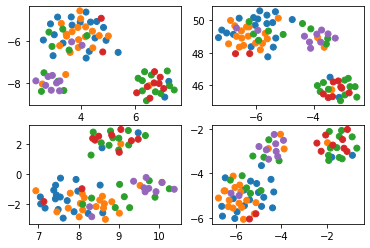

In [153]:
fig, ax = plt.subplots(2, 2)
data_size = data_ar.shape
fit = umap.UMAP(metric=crosscorr)
for a, noise in zip(ax.ravel(), [0, 0.02, 0.05, 0.1]):
    u = fit.fit_transform(data_ar[:, :1000]+noise*np.random.randn(data_size[0], 1000))
    a.scatter(u[:, 0], u[:, 1], c=colors)

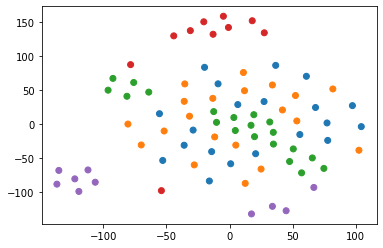

In [138]:
data_embedded = skman.TSNE(n_components=2).fit_transform(data_ar)
data_embedded.shape
plt.scatter(data_embedded[:, 0], data_embedded[:, 1], c=colors)

In [101]:
test_t = np.zeros((30, 1000))
test_x = np.zeros((30, 1000))
test_v = np.zeros((30, 1000))


for k in range(10):
    phase = np.random.uniform()*2*np.pi
    x = np.sin(2*np.pi*t+phase)
    t = np.cumsum(np.abs(np.random.randn(1000)/4+1))
    test_t[k, :] = t
    test_x[k, :] = x
for k in range(10, 20):
    const = np.random.uniform(-1, 1)
    x = np.ones((1000,))*const
    t = np.cumsum(np.abs(np.random.randn(1000)/4+1))
    test_t[k, :] = t
    test_x[k, :] = x
for k in range(20, 30):
    slope = np.random.uniform(-1, 1)
    x0 = np.random.uniform(-0.5, 0.5)
    t = np.cumsum(np.abs(np.random.randn(1000)/4+1))
    x = x0+slope*t
    test_t[k, :] = t
    test_x[k, :] = x

for k, (t, x) in enumerate(zip(test_t, test_x)):
    test_v[k, :] = np.gradient(x, t)
    
test_ar = np.hstack([test_x, test_v])

In [103]:
classifier = svm.SVC()
classifier.fit(data_ar, labels)

out = classifier.predict(test_ar)
display(out.reshape((3, 10)))

array([[0., 0., 4., 2., 1., 0., 0., 2., 0., 0.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [4., 3., 4., 3., 4., 1., 4., 4., 3., 4.]])

In [105]:
import tslearn.clustering as tsclust

/home/gknave/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


In [111]:
### Takes a VERY long time to run
#kmeans = tsclust.TimeSeriesKMeans(n_clusters=5, metric='softdtw').fit(data_ar)
#kmeans.labels_.reshape(4, 20)

## Histogram comparison

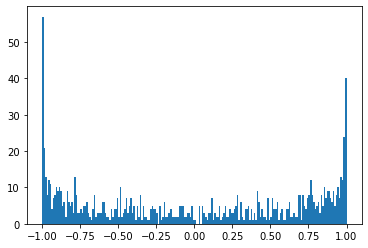

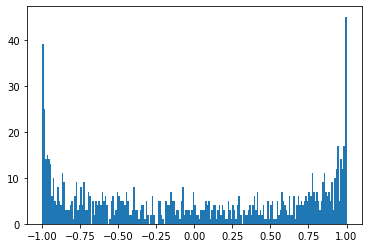

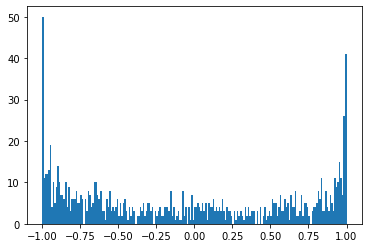

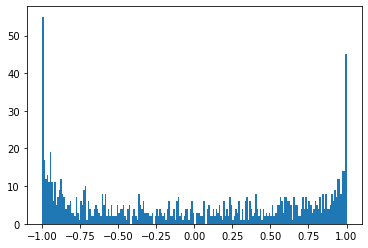

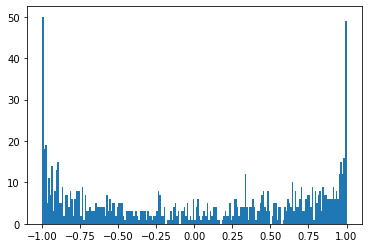

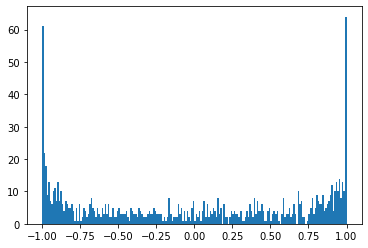

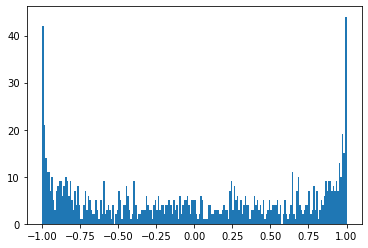

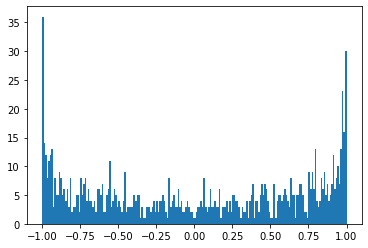

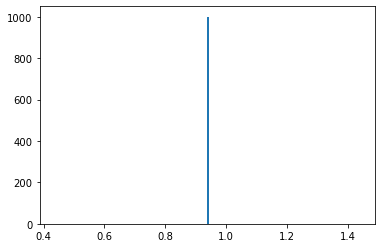

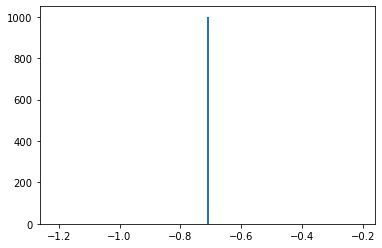

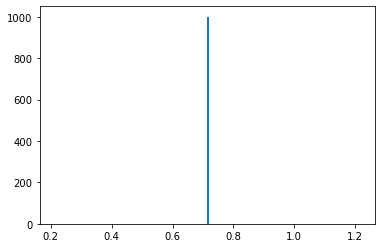

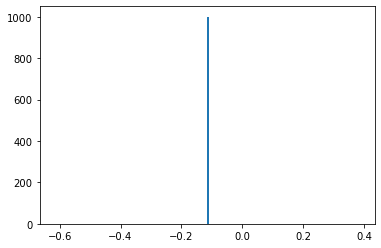

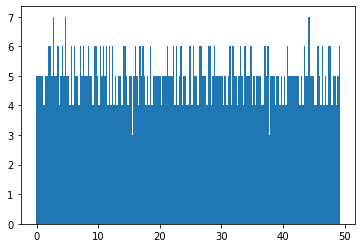

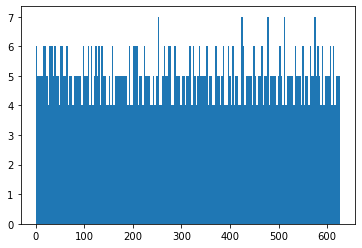

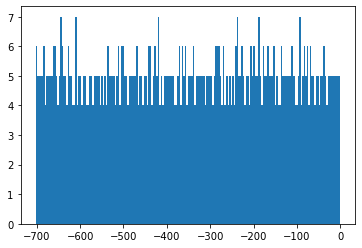

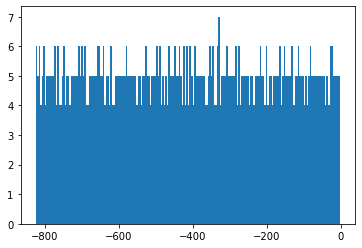

In [154]:
for row in x_ar[::5, :]:
    plt.figure()
    plt.hist(row, bins=200)

In [202]:
hist_data = np.zeros((80, 100))
for k in range(80):
    x = x_ar[k, :]+np.random.randn(1000)/10
    # Transform
    x -= np.mean(x)
    x /= np.max(np.abs(x))
    hist_data[k, :], _ = np.histogram(x, bins=100, range=(-1, 1), density=False)

(100,)

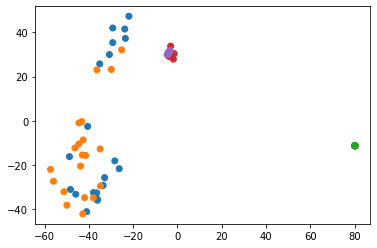

In [177]:
pca = decomp.PCA()
components = pca.fit_transform(hist_data)

plt.scatter(components[:, 0], components[:, 1], c=colors)

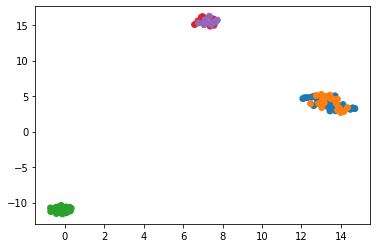

In [203]:
fit = umap.UMAP(metric='manhattan')
u = fit.fit_transform(hist_data)
plt.scatter(u[:, 0], u[:, 1], c=colors)